In [115]:
import requests
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    mean_squared_log_error, median_absolute_error, r2_score
from scipy.stats import pearsonr
import os
import eli5
import json

In [116]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [117]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
RELATIVE_GAIN_COLUMN_NAME = 'gain_in_r2_score'
SCORE_BEFORE_COLUMN_NAME = 'r2_score_before'
SCORE_AFTER_COLUMN_NAME = 'r2_score_after'
ABSOLUTE_GAIN_COLUMN_NAME = 'absolute_gain_r2'

In [118]:
def print_df(df):
    """Prints entire pandas dataframe.
    """
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.expand_frame_repr', False,
                           'display.max_colwidth', 70):
        print(df)

In [119]:
def get_dataset_name(id_):
    """Connects to Datamart to get the dataset name, given the dataset id.
    """
    
    response = requests.get(
        'http://localhost:8002/metadata/%s'%id_,
    )
    response.raise_for_status()
    
    return json.loads(response.text)['metadata']['name']

In [120]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

## Classification

In [121]:
def create_model(alpha, training_filename, feature_vector, target_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[target_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    clf = RandomForestClassifier(random_state=49, n_estimators=100)
    clf.fit(X_train, y_train)
    
    return clf

In [122]:
def predict_class_for_features(classifier, test_filename, feature_vector, target_column):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={target_column: 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    new_test_data = test_data[
        ['candidate_name', 'candidate_id', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']
    ].sort_values('g_r2', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    return (new_test_data, explanations)

In [123]:
def compute_precision_recall(df, print_records=True):
    
    tp_vals = list()
    index_tp = list()
    fp_vals = list()
    index_fp = list()
    tn_vals = list()
    index_tn = list()
    fn_vals = list()
    index_fn = list()
    
    for index, row in df.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tp.append(index)
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fn.append(index)
        elif row['g_r2'] <= 0 and row['class'] == 'gain':
            fp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fp.append(index)
        else:
            tn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tn.append(index)
            
    tp = len(tp_vals)
    fn = len(fn_vals)
    fp = len(fp_vals)
    tn = len(tn_vals)
            
    columns = ['name', 'g_r2', 'p(gain)', 'cf']
    tp_df = pd.DataFrame(tp_vals, columns=columns, index=index_tp)
    fn_df = pd.DataFrame(fn_vals, columns=columns, index=index_fn)
    fp_df = pd.DataFrame(fp_vals, columns=columns, index=index_fp)
    tn_df = pd.DataFrame(tn_vals, columns=columns, index=index_tn)
            
    print("-- Total:", tp+tn+fp+fn)
    print('')
    print("-- TP:", tp)
    if print_records:
        print_df(tp_df)
    print('')
    print("-- TN:", tn)
    if print_records:
        print_df(tn_df)
    print('')
    print("-- FP:", fp)
    if print_records:
        print_df(fp_df)
    print('')
    print("-- FN:", fn)
    if print_records:
        print_df(fn_df)
    print('')

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [124]:
def remove_gain_halfway(df):
    
    new_df = df.copy()
    new_df = new_df[(new_df['p(gain)'] <= 0.4) | (new_df['p(gain)'] >= 0.6)]
    
    return new_df

In [10]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

## Regression

In [125]:
def create_absolute_gain_column(df, score_before_column, score_after_column, column_name):
    df[column_name] = df[score_after_column] - df[score_before_column]

In [126]:
def create_regression_model_from_df(training_df, feature_vector, target_column):
    """This functions builds a regressor based on the training data (pandas.Dataframe).
    """

    X_train = training_df[feature_vector]
    y_train = training_df[target_column]
    
    regr = RandomForestRegressor(random_state=49, n_estimators=100)
    regr.fit(X_train, y_train)
    
    return regr

In [127]:
def create_regression_model(training_filename, feature_vector, target_column):
    """This functions builds a regressor based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    
    return create_regression_model_from_df(training_data, feature_vector, target_column)

In [128]:
def predict_value_for_features_from_df(regressor, test_df, feature_vector, target_column):
    
    # avoiding overflow
    for col in test_df.select_dtypes([np.number]).columns:
        test_df = test_df[test_df[col] < np.finfo(np.float32).max]
    test_df.reset_index(inplace=True)
    X_test = test_df[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    y_fit = regressor.predict(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(regressor, X_test.iloc[index]))
    
    test_df['predicted'] = y_fit
    test_df['candidate_id'] = test_df['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_df['candidate_name'] = test_df['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_df.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_df.rename(columns={target_column: 'real'}, inplace=True)
    
    new_test_data = test_df[
#        ['candidate_name', 'candidate_id', 'cf', 'real', 'predicted']
        ['candidate_name', 'cf', 'real', 'predicted']
    ].sort_values('real', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    print("Mean Absolute Error: %.4f" % mean_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("Mean Squared Error: %.4f" % mean_squared_error(new_test_data['real'], new_test_data['predicted']))
    print("Median Absolute Error: %.4f" % median_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("R2 Score: %.4f" % r2_score(new_test_data['real'], new_test_data['predicted']))
    
    return (new_test_data, explanations)

In [129]:
def predict_value_for_features(regressor, test_filename, feature_vector, target_column):

    test_data = pd.read_csv(test_filename)
    
    return predict_value_for_features_from_df(
        regressor,
        test_data,
        feature_vector,
        target_column
    )

In [13]:
rf_regressor = create_regression_model(
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

In [130]:
training_df_with_abolute_column = create_absolute_gain_column(
    pd.read_csv('../data/training-for-model.csv'),
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
rf_regressor_abs = create_regression_model(
    training_df=training_df_with_abolute_column,
    feature_vector=FEATURE_VECTOR,
    target_column=ABSOLUTE_GAIN_COLUMN_NAME
)

KeyError: 'r2_score_after'

## NY Taxi and Vehicle Collision Problem

### Classification

In [14]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [65]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- Total: 76

-- TP: 15
                                                                     name    g_r2  p(gain)      cf
1            Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.56000 0.14365
2            Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.56000 0.14365
3   Performance Metrics - Buildings - Time to Issue Developer Services... 4.02944  0.50000 0.14365
4   Performance Metrics - Buildings - Time to Issue Developer Services... 4.02944  0.50000 0.14365
12                                  Cash Assistance Recipients Since 1955 1.31017  0.51000 0.03315
13         Interagency Coordination and Construction Permits Data (MOSYS) 1.28968  0.55000 0.00552
14         Interagency Coordination and Construction Permits Data (MOSYS) 1.28968  0.55000 0.00552
16            Annual Allowable Rent Increase for Units Under Rent Control 1.28968  0.54000 0.00552
17                                                 Appeals Closed In 2015 1.28968  0.

In [66]:
compute_precision_recall(taxi_vehicle_collision_classes, print_records=False)

-- Total: 76

-- TP: 15

-- TN: 20

-- FP: 25

-- FN: 16

Precision: 0.3750
Recall: 0.4839


In [16]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.4056500620662548

In [17]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

-0.3169339453214221

In [ ]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [19]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

-0.2336705742925743

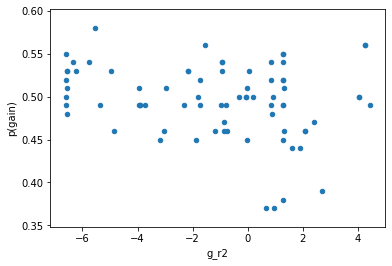

In [20]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

### Classification -- ignoring p(gain) between 0.4 and 0.6

In [82]:
taxi_vehicle_collision_classes_i = remove_gain_halfway(taxi_vehicle_collision_classes)

In [83]:
compute_precision_recall(taxi_vehicle_collision_classes_i)

-- Total: 4

-- TP: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- TN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FP: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FN: 4
                                                                     name    g_r2  p(gain)      cf
5                                               Daily Weather Data for NY 2.69791  0.39000 1.00000
21  Unemployment Insurance Initial Claims Statewide By Month: Beginnin... 1.27293  0.38000 0.03315
22        Gasoline Retail Prices Weekly Average by Region: Beginning 2007 0.95892  0.37000 0.14365
28           Diesel Retail Price Weekly Average by Region: Beginning 2007 0.65882  0.37000 0.14365

Precision: nan
Recall: 0.0000


In [84]:
compute_precision_recall(taxi_vehicle_collision_classes_i, print_records=False)

-- Total: 4

-- TP: 0

-- TN: 0

-- FP: 0

-- FN: 4

Precision: nan
Recall: 0.0000


In [85]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes_i, 'cf', 'g_r2')

0.926106746208552

In [86]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_i, 'cf', 'p(gain)')

0.8074866310160427

In [87]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_i, 'g_r2', 'p(gain)')

0.955460649581532

### Regression

In [21]:
taxi_vehicle_collision_predictions, taxi_vehicle_collision_regr_explanations = predict_value_for_features(
    rf_regressor,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 9.3866
Mean Squared Error: 1779.5266
Median Absolute Error: 2.2041
R2 Score: -181.6683


In [69]:
print_df(taxi_vehicle_collision_predictions)

                                                           candidate_name      cf     real  predicted
0                                                        DHS Daily Report 0.97238  4.43722    0.00758
1            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    1.60109
2            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    1.60109
3   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  4.02944    0.04510
4   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  4.02944    0.04510
5                                               Daily Weather Data for NY 1.00000  2.69791    0.01579
6                                 CTA - Ridership - Daily Boarding Totals 1.00000  2.42632    0.04974
7           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365  2.09037   -0.21477
8           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365 

In [23]:
taxi_vehicle_collision_regr_explanations[5]

,target,feature,weight,value
0,y,candidate_target_max_covariance,286.10360,9551887.31111
1,y,<BIAS>,1.98085,1.00000
2,y,query_max_skewness,0.09887,1.40835
3,y,query_num_of_columns,0.08742,2.00000
4,y,query_target_max_covariance,0.06946,176158.30261
5,y,candidate_target_max_pearson,0.05479,0.04764
6,y,query_num_of_rows,0.02633,181.00000
7,y,containment_fraction,-0.00469,0.03315
8,y,candidate_max_kurtosis,-0.00545,0.35314
9,y,candidate_max_skewness,-0.00678,0.64483


### Regression -- absolute diff in R2 score

In [21]:
taxi_vehicle_collision_records_features = create_absolute_gain_column(
    pd.read_csv('taxi-vehicle-collision-records-features'),
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
taxi_vehicle_collision_predictions_abs, taxi_vehicle_collision_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    taxi_vehicle_collision_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 9.3866
Mean Squared Error: 1779.5266
Median Absolute Error: 2.2041
R2 Score: -181.6683


In [69]:
print_df(taxi_vehicle_collision_predictions_abs)

                                                           candidate_name      cf     real  predicted
0                                                        DHS Daily Report 0.97238  4.43722    0.00758
1            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    1.60109
2            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    1.60109
3   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  4.02944    0.04510
4   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  4.02944    0.04510
5                                               Daily Weather Data for NY 1.00000  2.69791    0.01579
6                                 CTA - Ridership - Daily Boarding Totals 1.00000  2.42632    0.04974
7           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365  2.09037   -0.21477
8           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365 

## College Debt

### Classification

In [24]:
college_debt_classes, college_debt_explanations = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [70]:
compute_precision_recall(college_debt_classes)

-- Total: 41

-- TP: 20
                                                                     name    g_r2  p(gain)      cf
0                              Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.66000 1.00000
1                                    College Scorecard Data - Most Recent 0.72774  0.67000 1.00000
2              Chicago Public Schools - School Profile Information SY1617 0.01031  0.64000 0.00020
3              Chicago Public Schools - School Profile Information SY1718 0.00983  0.64000 0.00020
4                                          Public Pay Telephone Locations 0.00903  0.66000 0.01222
5                                                      Muni Simple Routes 0.00780  0.64000 0.00200
6                 Chicago Public Schools - School Progress Reports SY1819 0.00718  0.64000 0.00020
7                                    Lobbyist Data - Expenditures - Small 0.00703  0.71000 0.00160
8              Chicago Public Schools - School Profile Information SY1819 0.00700  0.

In [71]:
compute_precision_recall(college_debt_classes, print_records=False)

-- Total: 41

-- TP: 20

-- TN: 0

-- FP: 21

-- FN: 0

Precision: 0.4878
Recall: 1.0000


In [26]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

0.7769692883819711

In [27]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

0.06136839539263857

In [28]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

-0.09986292866855787

### Classification -- ignoring p(gain) between 0.4 and 0.6

In [88]:
college_debt_classes_i = remove_gain_halfway(college_debt_classes)

In [89]:
compute_precision_recall(college_debt_classes_i)

-- Total: 41

-- TP: 20
                                                                     name    g_r2  p(gain)      cf
0                              Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.66000 1.00000
1                                    College Scorecard Data - Most Recent 0.72774  0.67000 1.00000
2              Chicago Public Schools - School Profile Information SY1617 0.01031  0.64000 0.00020
3              Chicago Public Schools - School Profile Information SY1718 0.00983  0.64000 0.00020
4                                          Public Pay Telephone Locations 0.00903  0.66000 0.01222
5                                                      Muni Simple Routes 0.00780  0.64000 0.00200
6                 Chicago Public Schools - School Progress Reports SY1819 0.00718  0.64000 0.00020
7                                    Lobbyist Data - Expenditures - Small 0.00703  0.71000 0.00160
8              Chicago Public Schools - School Profile Information SY1819 0.00700  0.

In [90]:
compute_precision_recall(college_debt_classes_i, print_records=False)

-- Total: 41

-- TP: 20

-- TN: 0

-- FP: 21

-- FN: 0

Precision: 0.4878
Recall: 1.0000


In [91]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_i, 'cf', 'g_r2')

0.7769692883819711

In [92]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_i, 'cf', 'p(gain)')

0.06136839539263857

In [93]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_i, 'g_r2', 'p(gain)')

-0.09986292866855787

### Regression

In [29]:
college_debt_predictions, college_debt_regr_explanations = predict_value_for_features(
    rf_regressor,
    'college-debt-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 1.1474
Mean Squared Error: 2.1223
Median Absolute Error: 0.7828
R2 Score: -64.8561


In [74]:
print_df(college_debt_predictions)

                                                           candidate_name      cf     real  predicted
0                              Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.80812   -0.00855
1                                    College Scorecard Data - Most Recent 1.00000  0.72774   -0.01164
2              Chicago Public Schools - School Profile Information SY1617 0.00020  0.01031    2.28998
3              Chicago Public Schools - School Profile Information SY1718 0.00020  0.00983    2.28998
4                                          Public Pay Telephone Locations 0.01222  0.00903    0.04515
5                                                      Muni Simple Routes 0.00200  0.00780    2.39723
6                 Chicago Public Schools - School Progress Reports SY1819 0.00020  0.00718    2.26294
7                                    Lobbyist Data - Expenditures - Small 0.00160  0.00703    1.85116
8              Chicago Public Schools - School Profile Information SY1819 0.00020 

### Regression -- absolute diff in R2 score

In [29]:
college_debt_records_features = create_absolute_gain_column(
    pd.read_csv('college-debt-records-features'),
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
college_debt_predictions_abs, college_debt_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    college_debt_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 1.1474
Mean Squared Error: 2.1223
Median Absolute Error: 0.7828
R2 Score: -64.8561


In [74]:
print_df(college_debt_predictions_abs)

                                                           candidate_name      cf     real  predicted
0                              Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.80812   -0.00855
1                                    College Scorecard Data - Most Recent 1.00000  0.72774   -0.01164
2              Chicago Public Schools - School Profile Information SY1617 0.00020  0.01031    2.28998
3              Chicago Public Schools - School Profile Information SY1718 0.00020  0.00983    2.28998
4                                          Public Pay Telephone Locations 0.01222  0.00903    0.04515
5                                                      Muni Simple Routes 0.00200  0.00780    2.39723
6                 Chicago Public Schools - School Progress Reports SY1819 0.00020  0.00718    2.26294
7                                    Lobbyist Data - Expenditures - Small 0.00160  0.00703    1.85116
8              Chicago Public Schools - School Profile Information SY1819 0.00020 

## Poverty Estimation

### Classification

In [31]:
poverty_estimation_classes, poverty_estimation_explanations = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [75]:
compute_precision_recall(poverty_estimation_classes)

-- Total: 2231

-- TP: 262
                                                                      name    g_r2  p(gain)      cf
0                                       State WASL Scores by Subgroup_2008 0.03277  0.56000 0.00032
1                                   State MSP-HSPE Scores by Subgroup_2009 0.03277  0.53000 0.00064
2                                   State MSP-HSPE Scores by Subgroup_2010 0.03140  0.51000 0.00191
3                                 2013 - 2018 Demographic Snapshot Borough 0.02960  0.52000 0.00032
4                                 2013 - 2018 Demographic Snapshot Borough 0.02960  0.52000 0.00032
5                                 2013 - 2018 Demographic Snapshot Borough 0.02960  0.52000 0.00032
6                                    County Agricultural Districts Profile 0.02846  0.53000 0.00159
7                                                   Unemployment in the US 0.02825  0.60000 1.00000
8                                       CTE Demographic Data by State_201

In [76]:
compute_precision_recall(poverty_estimation_classes, print_records=False)

-- Total: 2231

-- TP: 262

-- TN: 371

-- FP: 1559

-- FN: 39

Precision: 0.1439
Recall: 0.8704


In [33]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.0539733970678087

In [34]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

-0.0068814391725841965

In [35]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.10254580160218839

In [36]:
poverty_estimation_explanations[0]

,target,feature,weight,value
0,gain,<BIAS>,0.56052,1.00000
1,gain,query_max_unique,0.10101,2790.00000
2,gain,max_pearson_difference,0.04258,0.29249
3,gain,candidate_target_max_mutual_info,0.03167,0.03312
4,gain,candidate_max_skewness,0.02484,5.51549
5,gain,containment_fraction,0.01734,0.00096
6,gain,query_num_of_rows,0.01620,3136.00000
7,gain,candidate_row_column_ratio,0.01096,17.36364
8,gain,candidate_max_kurtosis,0.00905,33.89343
9,gain,query_target_max_covariance,0.00708,55411.93728


### Classification -- ignoring p(gain) between 0.4 and 0.6

In [94]:
poverty_estimation_classes_i = remove_gain_halfway(poverty_estimation_classes)

In [95]:
compute_precision_recall(poverty_estimation_classes_i)

-- Total: 32

-- TP: 10
                                                                      name    g_r2  p(gain)      cf
7                                                   Unemployment in the US 0.02825  0.60000 1.00000
20   State University of New York (SUNY) Trends in Enrollment of Studen... 0.01995  0.60000 0.00128
54                                      CTE Demographic Data by State_2009 0.01483  0.60000 0.00064
89                               2013 - 2018 Demographic Snapshot District 0.01270  0.60000 0.00255
102    2010 - 2011 School Attendance and Enrollment Statistics by District 0.01222  0.60000 0.00096
103               2009 - 2010 School Attendance And Enrollment By District 0.01222  0.60000 0.00096
113                              2013 - 2018 Demographic Snapshot District 0.01142  0.61000 0.00191
130            2013 - 2015 New York State English Language Arts (ELA) Exam 0.01008  0.62000 0.00255
221  Census Data - Selected socioeconomic indicators in Chicago, 2008 –... 0

In [96]:
compute_precision_recall(poverty_estimation_classes_i, print_records=False)

-- Total: 32

-- TP: 10

-- TN: 1

-- FP: 21

-- FN: 0

Precision: 0.3226
Recall: 1.0000


In [97]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes_i, 'cf', 'g_r2')

0.2177479148298039

In [98]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes_i, 'cf', 'p(gain)')

-0.00788269576023548

In [99]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes_i, 'g_r2', 'p(gain)')

0.15182172236567598

### Regression

In [37]:
poverty_estimation_predictions, poverty_estimation_regr_explanations = predict_value_for_features(
    rf_regressor,
    'poverty-estimation-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 7.5873
Mean Squared Error: 3609.4113
Median Absolute Error: 0.4772
R2 Score: -217089.1465


In [100]:
print_df(poverty_estimation_predictions)

                                                             candidate_name      cf     real  predicted
0                                        State WASL Scores by Subgroup_2008 0.00032  0.03277    2.18916
1                                    State MSP-HSPE Scores by Subgroup_2009 0.00064  0.03277    0.22414
2                                    State MSP-HSPE Scores by Subgroup_2010 0.00191  0.03140   -0.30475
3                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    2.22786
4                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    2.22786
5                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    2.22786
6                                     County Agricultural Districts Profile 0.00159  0.02846   -0.16036
7                                                    Unemployment in the US 1.00000  0.02825    0.17675
8                                        CTE Demographic Data by

### Regression -- absolute diff in R2 score

In [37]:
poverty_estimation_records_features = create_absolute_gain_column(
    pd.read_csv('poverty-estimation-records-features'),
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
poverty_estimation_predictions_abs, poverty_estimation_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    poverty_estimation_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 7.5873
Mean Squared Error: 3609.4113
Median Absolute Error: 0.4772
R2 Score: -217089.1465


In [100]:
print_df(poverty_estimation_predictions_abs)

                                                             candidate_name      cf     real  predicted
0                                        State WASL Scores by Subgroup_2008 0.00032  0.03277    2.18916
1                                    State MSP-HSPE Scores by Subgroup_2009 0.00064  0.03277    0.22414
2                                    State MSP-HSPE Scores by Subgroup_2010 0.00191  0.03140   -0.30475
3                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    2.22786
4                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    2.22786
5                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    2.22786
6                                     County Agricultural Districts Profile 0.00159  0.02846   -0.16036
7                                                    Unemployment in the US 1.00000  0.02825    0.17675
8                                        CTE Demographic Data by